# Interpret Results of Trained GCN
In this notebook, I'll try to visualize the learning of a trained GCN model. This should involve the following steps:
* Interpret the predictions made by the model
* Visualize the filters of the Graph Convolution
* Do a TSNE plot of the last layer

In [2]:
# classics
import numpy as np
import pandas as pd
import random, h5py
import tensorflow as tf
import math

# my tool and sparse stuff for feature extraction
import gcn.utils
import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse import coo_matrix
import scipy.sparse as sp

sys.path.append(os.path.abspath('../pagerank'))
import pagerank

# sklearn imports
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import matplotlib.mlab as mlab
plt.rc('font', family='Times New Roman')

# set options
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def str_to_num(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            return s

def load_hyper_params(model_dir):
    file_name = os.path.join(model_dir, 'hyper_params.txt')
    input_file = None
    with open(file_name, 'r') as f:
        args = {}
        for line in f.readlines():
            if '\t' in line:
                key, value = line.split('\t')
                if value.startswith('['): # list of hidden dimensions
                    f = lambda x: "".join(c for c in x if c not in ['\"', '\'', ' ', '\n', '[', ']']) 
                    l = [int(f(i)) for i in value.split(',')]
                    args[key.strip()] = l
                else:
                    args[key.strip()] = str_to_num(value.strip())
            else:
                input_file = line.strip()
    print ("Hyper-Parameters read from {}".format(file_name))
    return args, input_file

In [71]:
model_dir = '../data/GCN/training/2018_07_20_17_26_54/'

args, data_file = load_hyper_params(model_dir)
#data_file = '../data/cancer/hotnet_iref_vec_input_unbalanced.h5'
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    #features_mean = f['features_mean'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

Hyper-Parameters read from ../data/GCN/training/2018_07_20_17_26_54/hyper_params.txt
Data comes from ../data/pancancer/iref_multiomics_norm.h5
{'hidden_dims': [20, 40, 20], 'decay': 0.0005, 'lr': 0.001, 'loss_mul': 175.0, 'dropout': 0.5, 'data': '../data/pancancer/iref_multiomics_norm.h5', 'epochs': 10000, 'support': 2}


## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [72]:
features.shape, node_names.shape, network.shape

((12129, 47), (12129, 2), (12129, 12129))

In [73]:
# load predictions
predictions = pd.DataFrame.from_csv(os.path.join(model_dir, 'predictions.tsv'), sep='\t', header=0)
features_df = pd.DataFrame(features, index=node_names[:, 0])
features_df['Name'] = node_names[:, 1]
features_df['neighbors'] = network.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner', lsuffix='_')
print (pred_with_feat.shape)
pos_predicted = pred_with_feat[pred_with_feat.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0])
labels_df['training_set'] = train_mask
labels_df['testing_set'] = test_mask
labels_df['label'] = np.logical_or(train_mask, test_mask).astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_nofeat = predictions[predictions.Prob_pos >= CLASSIFICATION_THRESHOLD]
pos_nofeat.sort_values(by='Prob_pos', ascending=False).to_csv(os.path.join(model_dir, 'positive_prediction.txt'),
                                                                 sep='\t')

(12135, 51)
Predicted 1531 genes of 12129 total to be involved in infection


Correlation of prediction with #neighbors: 0.31419745251810555
Correlation of prediction with #neighbors for positives: 0.30437479812456314


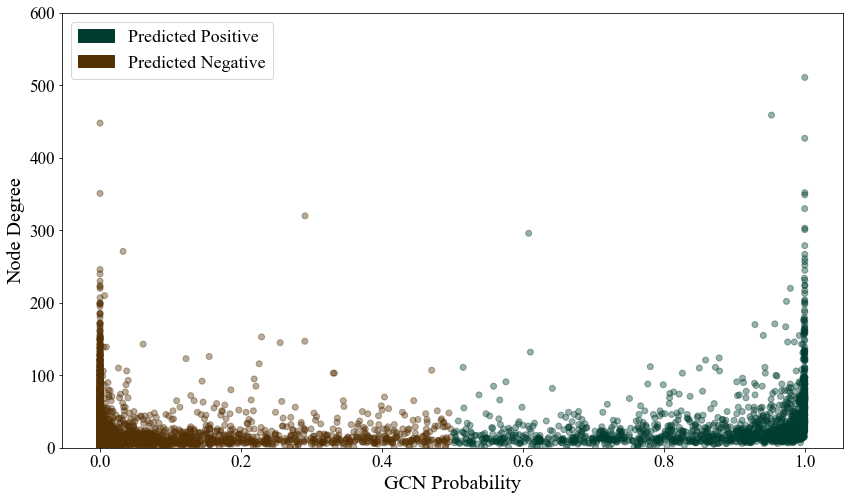

In [74]:
fig = plt.figure(figsize=(14, 8))
cmap = plt.cm.BrBG
plt.scatter(pred_with_feat.Prob_pos, pred_with_feat.neighbors,
            c=pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD,
            cmap=cmap, alpha=.4)
plt.gca().set_ylim([0, 600])
plt.xlabel('GCN Probability', fontsize=20)
plt.ylabel('Node Degree', fontsize=20)
plt.tick_params(axis='both', labelsize=17)
pred = mpatches.Patch(color=cmap(1000), label='Predicted Positive')
non_pred = mpatches.Patch(color=cmap(0), label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left', prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'degree_correlation.png'))

df_pos = pred_with_feat[pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD]
print ("Correlation of prediction with #neighbors: {}".format(pred_with_feat.Prob_pos.corr(pred_with_feat.neighbors)))
print ("Correlation of prediction with #neighbors for positives: {}".format(df_pos.Prob_pos.corr(df_pos.neighbors)))

In [75]:
labels_with_pred = labels_df.join(predictions, lsuffix='_', how='inner')
predictions_for_pos = labels_with_pred[labels_with_pred.positive == 1]
true_positives = predictions_for_pos[predictions_for_pos.Prob_pos > CLASSIFICATION_THRESHOLD]
no_tp = true_positives.shape[0]
no_positives = predictions_for_pos.shape[0]
pred_pos_test = true_positives[true_positives.testing_set == 1]
pred_pos_train = true_positives[true_positives.training_set == 1]
predictions_for_neg = labels_with_pred[labels_with_pred.negative == 1]
true_negatives = predictions_for_neg[predictions_for_neg.Prob_pos <= CLASSIFICATION_THRESHOLD]
no_tn = true_negatives.shape[0]
no_fn = predictions_for_neg[predictions_for_neg.Prob_pos > CLASSIFICATION_THRESHOLD].shape[0]

print ("Predicted {} out of {} known infection genes".format(no_tp, no_positives)
      )
print ("Out of these {}, {} were not shown during training.".format(no_positives,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_pos_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_pos_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_pos_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_pos_train.shape[0]/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} genes (True Negatives) ({}%)".format(no_tn,
                                                                     predictions_for_neg.shape[0],
                                                                     no_tn/predictions_for_neg.shape[0]*100.))
print ("Falsely predicted {} negatives (FN)".format(no_fn))
predictions_for_neg.sort_values(by='Prob_pos', ascending=False).head(20)

Predicted 93 out of 123 known infection genes
Out of these 123, 49 were not shown during training.
Predicted 32 out of 49 test genes (65.3061224489796%)
Predicted 61 out of 74 train genes (82.43243243243244%)
Correctly rejected 2117 out of 2258 genes (True Negatives) (93.75553587245349%)
Falsely predicted 141 negatives (FN)


,Name_,positive,training_set,testing_set,label,negative,Name,Prob_pos
ENSG00000158092,NCK1,0,1,0,1,1,NCK1,1.000
ENSG00000114166,KAT2B,0,0,1,1,1,KAT2B,1.000
ENSG00000061273,HDAC7,0,1,0,1,1,HDAC7,1.000
ENSG00000188612,SUMO2,0,0,1,1,1,SUMO2,0.998
ENSG00000078043,PIAS2,0,0,1,1,1,PIAS2,0.998
ENSG00000160999,SH2B2,0,0,1,1,1,SH2B2,0.998
ENSG00000116962,NID1,0,1,0,1,1,NID1,0.998
ENSG00000076641,PAG1,0,0,1,1,1,PAG1,0.997
ENSG00000102981,PARD6A,0,0,1,1,1,PARD6A,0.996
ENSG00000167004,PDIA3,0,1,0,1,1,PDIA3,0.996


## Train other Classifiers on the Features for Comparison
In order to evaluate our method, let's compare it's power to other algorithms. For now, I'll focus on ones, that operate on the features alone and algorithms that operate on the network alone.
The comparison is with:
* **SVM classifier**: A very powerful, non-linear method that generally does not really overfit and can deal with little data. This should be an upper bound on what one can reach on the features alone.
* **Logistic regression**: This is a linear algorithm, also only operating on the features. It is less powerful than an SVM.
* **PageRank**: A network ranking method that only computes the most important nodeso in the network. It's completely blind to the features.

In [76]:
# train SVM on features and evaluate on test set and all genes
X_train = features[train_mask.astype(np.bool)]
y_train_svm = y_train[train_mask.astype(np.bool)]

X_test = features[test_mask.astype(np.bool)]
y_test_svm = y_test[test_mask.astype(np.bool)]

clf = svm.SVC(kernel='poly', probability=True, C=.0001, class_weight='balanced')
clf.fit(X_train, y_train_svm.reshape(-1))

pred_svm = clf.predict_proba(X_test)
print ("Number of predicted genes in Test set (SVM): {}".format(pred_svm.argmax(axis=1).sum()))
pred_svm_all = clf.predict_proba(features)
print ("SVM predicts {} genes in total".format(np.argmax(pred_svm_all, axis=1).sum()))

Number of predicted genes in Test set (SVM): 0
SVM predicts 41 genes in total


In [77]:
svm_labels = labels_df
svm_labels['svm_scores'] = pred_svm_all[:, 1]
svm_labels[svm_labels.svm_scores >= CLASSIFICATION_THRESHOLD]

pred_pos_svm = svm_labels[svm_labels.positive == 1]
tp_svm = pred_pos_svm[pred_pos_svm.svm_scores > CLASSIFICATION_THRESHOLD]
no_tp_svm = tp_svm.shape[0]
no_pos_svm = pred_pos_svm.shape[0]
no_pos_test_svm = tp_svm[tp_svm.testing_set == 1].shape[0]
no_pos_train_svm = tp_svm[tp_svm.training_set == 1].shape[0]
pred_neg_svm = svm_labels[svm_labels.negative == 1]
tn_svm = pred_neg_svm[pred_neg_svm.svm_scores <= CLASSIFICATION_THRESHOLD]
no_tn_svm = tn_svm.shape[0]
no_fn_svm = pred_neg_svm[pred_neg_svm.svm_scores > CLASSIFICATION_THRESHOLD].shape[0]

print ("Predicted {} out of {} known infection genes".format(no_tp_svm, no_pos_svm)
      )
print ("Out of these {}, {} were not shown during training.".format(no_pos_svm,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(no_pos_test_svm,
                                                        y_test[:,0].sum(),
                                                        no_pos_test_svm/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(no_pos_train_svm,
                                                         y_train[:,0].sum(),
                                                         no_pos_train_svm/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} genes (True Negatives) ({}%)".format(no_tn_svm,
                                                                     pred_neg_svm.shape[0],
                                                                     no_tn_svm/pred_neg_svm.shape[0]*100.))
print ("Falsely predicted {} negatives (FN)".format(no_fn_svm))

Predicted 1 out of 123 known infection genes
Out of these 123, 49 were not shown during training.
Predicted 0 out of 49 test genes (0.0%)
Predicted 1 out of 74 train genes (1.3513513513513513%)
Correctly rejected 2256 out of 2257 genes (True Negatives) (99.95569339831634%)
Falsely predicted 1 negatives (FN)


In [78]:
# train random forest on the features only and predict for test set and all genes
rf = RandomForestClassifier()
rf.fit(X_train, y_train_svm.reshape(-1))
pred_rf = rf.predict_proba(X_test)
print ("Number of predicted genes in Test set (RF): {}".format(pred_rf.argmax(axis=1).sum()))
pred_rf_all = rf.predict_proba(features)
print ("RF predicts {} genes in total".format(np.argmax(pred_rf_all, axis=1).sum()))

Number of predicted genes in Test set (RF): 20
RF predicts 197 genes in total


In [79]:
# train logistic regression on the features only and predict for test set and all genes
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train_svm.reshape(-1))
pred_lr = logreg.predict_proba(X_test)
print ("Number of predicted genes in Test set (LogReg): {}".format(pred_lr.argmax(axis=1).sum()))
pred_lr_all = logreg.predict_proba(features)
print ("LogReg predicts {} genes in total".format(np.argmax(pred_lr_all, axis=1).sum()))

Number of predicted genes in Test set (LogReg): 270
LogReg predicts 3541 genes in total


(12129, 7) (12135, 51)
Correlation of prediction with #neighbors: 0.31419745251810555
Correlation of prediction with #neighbors for positives: 0.30437479812456314


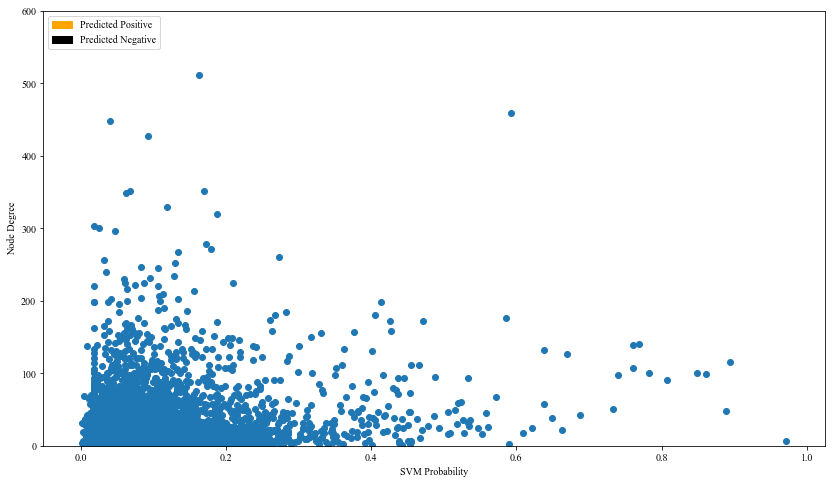

In [80]:
print (svm_labels.shape, pred_with_feat.shape)
fig = plt.figure(figsize=(14, 8))
plt.scatter(svm_labels.svm_scores, network.sum(axis=1),
            cmap=plt.cm.copper, alpha=1)
plt.gca().set_ylim([0, 600])
plt.xlabel('SVM Probability')
plt.ylabel('Node Degree')
pred = mpatches.Patch(color='orange', label='Predicted Positive')
non_pred = mpatches.Patch(color='black', label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left')
fig.savefig(os.path.join(model_dir, 'degree_correlation_svm.png'))

df_pos = pred_with_feat[pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD]
print ("Correlation of prediction with #neighbors: {}".format(pred_with_feat.Prob_pos.corr(pred_with_feat.neighbors)))
print ("Correlation of prediction with #neighbors for positives: {}".format(df_pos.Prob_pos.corr(df_pos.neighbors)))

In [81]:
# train pagerank on the network
scores, names = pagerank.pagerank(network, node_names)
pr_df = pd.DataFrame(scores, columns=['Number', 'Score'])
names = pd.DataFrame(names, columns=['ID', 'Name'])
pr_pred_all = pr_df.join(names, on='Number', how='inner')
pr_pred_test = pr_pred_all[pr_pred_all.ID.isin(node_names[test_mask == 1][:, 0])]

Maximum Pagerank: Index: 11270	Pagerank: 0.006650312418214648
Minimum Pagerank: Index: 3508	Pagerank: 1.503088157884692e-05


In [82]:
# do a random walk with restart and use HotNet2 heat as p_0

# read heat json from file
heat_df = pd.read_json('../../hotnet2/heat_syn_cnasnv.json').drop('parameters', axis=1)
heat_df.dropna(axis=0, inplace=True)

# join with node names to get correct order and only genes present in network
nn = pd.DataFrame(node_names, columns=['ID', 'Name'])
heat_df = nn.merge(heat_df, left_on='Name', right_index=True, how='left')
heat_df.fillna(0, inplace=True)

# add normalized heat
heat_df['heat_norm'] = heat_df.heat / heat_df.heat.sum()

print (heat_df.sum())
p_0 = heat_df.heat_norm

ID           ENSG00000121410ENSG00000148584ENSG00000175899E...
Name         A1BGA1CFA2MAAASAADATAAGABAAMPAANATAARSAARS2AAR...
heat                                                    51.189
heat_norm                                                1.000
dtype: object


In [83]:
beta = 0.3
W = network / network.sum(axis=0) # normalize A
assert (np.allclose(W.sum(axis=0), 1)) # assert that rows/cols sum to 1

p = np.linalg.inv(beta * (np.eye(network.shape[0]) - (1 - beta) * W)).dot(np.array(p_0))
rwr_ranks = np.argsort(p)[::-1]
heat_df['rwr_score'] = p
rwr_pred_test = heat_df[test_mask == 1].rwr_score

(12129, 2) (952,)
ACCURACY: 0.9212184873949579


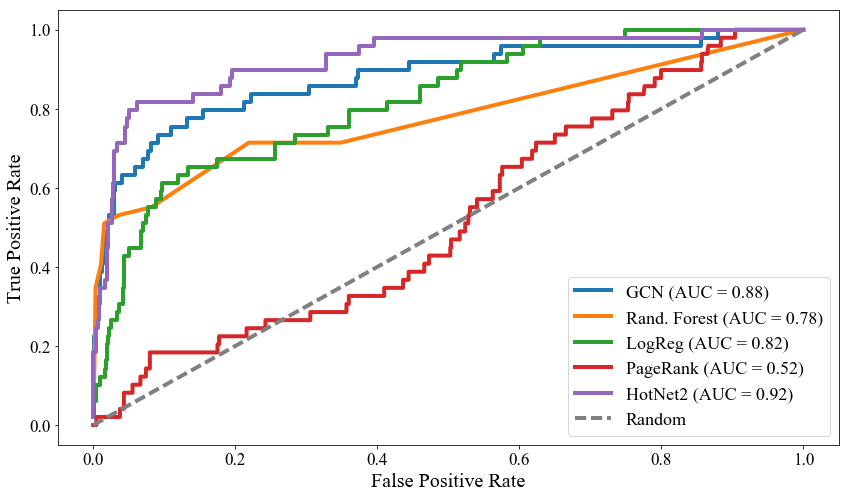

In [84]:
linewidth = 4
labelfontsize = 20
ticksize = 17
#y_score = predictions.Prob_pos
#y_true = np.logical_or(y_train, y_test)
y_true = y_test[test_mask == 1, 0]
y_score = predictions[test_mask == 1].Prob_pos
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
roc_auc = roc_auc_score(y_true=y_true, y_score=y_score)

# compute roc for SVM
print (pred_svm_all.shape, y_true.shape)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_true=y_true, y_score=pred_svm[:, 1])
roc_auc_svm = roc_auc_score(y_true=y_true, y_score=pred_svm[:, 1])

# compute roc for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true=y_true, y_score=pred_rf[:, 1])
roc_auc_rf = roc_auc_score(y_true=y_true, y_score=pred_rf[:, 1])

# compute ROC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_true=y_true, y_score=pred_lr[:, 1])
roc_auc_lr = roc_auc_score(y_true=y_true, y_score=pred_lr[:, 1])

# compute ROC for PageRank
fpr_pr, tpr_pr, thresholds_pr = roc_curve(y_true=y_true, y_score=pr_pred_test.Score)
roc_auc_pr = roc_auc_score(y_true=y_true, y_score=pr_pred_test.Score)

# compute ROC for RWR with HotNet2 heat scores
fpr_hotnet, tpr_hotnet, thresholds_hotnet = roc_curve(y_true=y_true, y_score=rwr_pred_test)
roc_auc_hotnet = roc_auc_score(y_true=y_true, y_score=rwr_pred_test)

# plot ROC curve
fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, lw=linewidth, label='GCN (AUC = {0:.2f})'.format(roc_auc))
plt.plot(fpr_rf, tpr_rf, lw=linewidth, label='Rand. Forest (AUC = {0:.2f})'.format(roc_auc_rf))
plt.plot(fpr_lr, tpr_lr, lw=linewidth, label='LogReg (AUC = {0:.2f})'.format(roc_auc_lr))
plt.plot(fpr_pr, tpr_pr, lw=linewidth, label='PageRank (AUC = {0:.2f})'.format(roc_auc_pr))
plt.plot(fpr_hotnet, tpr_hotnet, lw=linewidth, label='HotNet2 (AUC = {0:.2f})'.format(roc_auc_hotnet))
plt.plot([0, 1], [0, 1], color='gray', lw=linewidth, linestyle='--', label='Random')
plt.xlabel('False Positive Rate', fontsize=labelfontsize)
plt.ylabel('True Positive Rate', fontsize=labelfontsize)
plt.tick_params(axis='both', labelsize=ticksize)
#plt.title('ROC Curve')
plt.legend(loc='lower right', prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'roc_curve.svg'))
acc = accuracy_score(y_true=y_true,
                     y_pred=y_score >= CLASSIFICATION_THRESHOLD)
print ("ACCURACY: {}".format(acc))

In [85]:
distances = np.sqrt(np.sum((np.array([0, 1]) - np.array([fpr, tpr]).T)**2, axis=1))
idx = np.argmin(distances)
best_threshold = thresholds[idx]
print ("Optimal classification threshold: {}".format(best_threshold))

BEST_THRESHOLD = best_threshold

Optimal classification threshold: 0.030629508197307587


0.051470588235294115 49 903.0


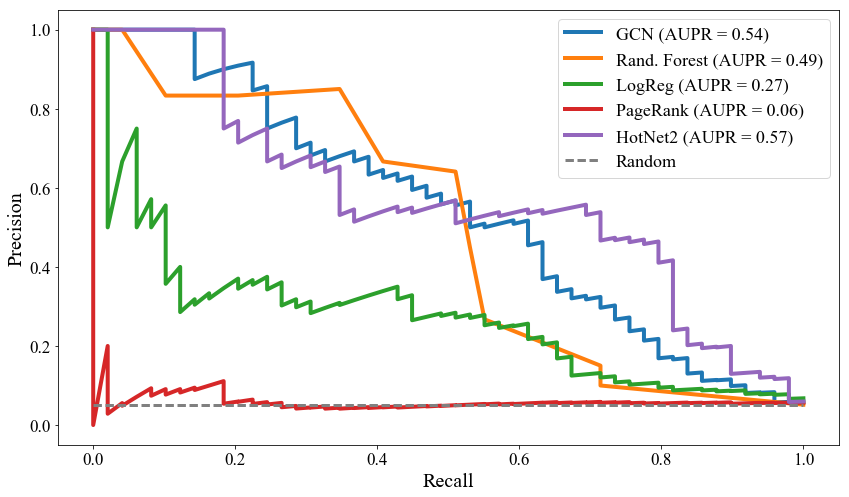

In [86]:
linewidth = 4
labelfontsize = 20
ticksize = 17
# calculate precision and recall for GCN
pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
aupr = average_precision_score(y_true=y_true, y_score=y_score)

# calculate precision and recall for SVM
pr_svm, rec_svm, thresholds_svm = precision_recall_curve(y_true=y_true, probas_pred=pred_svm[:, 1])
aupr_svm = average_precision_score(y_true=y_true, y_score=pred_svm[:, 1])

# calculate precision and recall for RF
pr_rf, rec_rf, thresholds_rf = precision_recall_curve(y_true=y_true, probas_pred=pred_rf[:, 1])
aupr_rf = average_precision_score(y_true=y_true, y_score=pred_rf[:, 1])

# calculate precision and recall for Logistic Regression
pr_lr, rec_lr, thresholds_lr = precision_recall_curve(y_true=y_true, probas_pred=pred_lr[:, 1])
aupr_lr = average_precision_score(y_true=y_true, y_score=pred_lr[:, 1])

# calculate precision and recall for PageRank
pr_pr, rec_pr, thresholds_pr = precision_recall_curve(y_true=y_true, probas_pred=pr_pred_test.Score)
aupr_pr = average_precision_score(y_true=y_true, y_score=pr_pred_test.Score)

# calculate precision and recall for Hotnet2
pr_hotnet, rec_hotnet, thresholds_hotnet = precision_recall_curve(y_true=y_true, probas_pred=rwr_pred_test)
aupr_hotnet = average_precision_score(y_true=y_true, y_score=rwr_pred_test)

fig = plt.figure(figsize=(14, 8))
plt.plot(rec, pr, lw=linewidth, label='GCN (AUPR = {0:.2f})'.format(aupr))
#plt.plot(rec_svm, pr_svm, lw=linewidth, label='SVM (AUPR = {0:.2f})'.format(aupr_svm))
plt.plot(rec_rf, pr_rf, lw=linewidth, label='Rand. Forest (AUPR = {0:.2f})'.format(aupr_rf))
plt.plot(rec_lr, pr_lr, lw=linewidth, label='LogReg (AUPR = {0:.2f})'.format(aupr_lr))
plt.plot(rec_pr, pr_pr, lw=linewidth, label='PageRank (AUPR = {0:.2f})'.format(aupr_pr))
plt.plot(rec_hotnet, pr_hotnet, lw=linewidth, label='HotNet2 (AUPR = {0:.2f})'.format(aupr_hotnet))
random_y = y_true.sum() / (y_true.sum() + y_true.shape[0] - y_true.sum())
print (random_y, y_true.sum(), y_true.shape[0]-y_true.sum())
plt.plot([0, 1], [random_y, random_y], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(axis='both', labelsize=ticksize)
#plt.title('Precision-Recall Curve')
plt.legend(loc='upper right', prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'prec_recall.png'))

#pr, rec

## Investigate New Model GCN Parameters

In [68]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = os.path.join(model_dir, "model.ckpt")
#print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=True)


In [69]:
tf.reset_default_graph()
adj = csr_matrix(network)
num_nodes = adj.shape[0]
num_feat = features.shape[1]
if num_feat > 1:
    F = gcn.utils.preprocess_features(lil_matrix(features))
else:
    print("Not row-normalizing features because feature dim is {}".format(num_feat))
    F = gcn.utils.sparse_to_tuple(lil_matrix(features))
print (args)
poly_support = args['support']
if poly_support > 0:
    support = gcn.utils.chebyshev_polynomials(adj, poly_support)
    num_supports = 1 + poly_support
else: # support is 0, don't use the network
    support = [sp.eye(adj.shape[0])]
    num_supports = 1
print (len(support))
print ([s[2] for s in support])
print (y_train.shape)
print (features.shape)

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32,
                                      shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = gcn.utils.construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_dir)
ckpt.model_checkpoint_path

if ckpt and ckpt.model_checkpoint_path:
    with tf.Session() as sess:
        model = MYGCN(placeholders,
                      input_dim=features.shape[1],
                      learning_rate=args['lr'],
                      hidden_dims=args['hidden_dims'],
                      pos_loss_multiplier=args['loss_mul'],
                      weight_decay=args['decay'],
                      num_hidden_layers=len(args['hidden_dims']),
                      logging=True)
        model.load(checkpoint_path, sess)
        print ("loaded")
        weight_matrices = []
        for var in model.vars: # chebychev coefficients
            weight_matrices.append(model.vars[var].eval(session=sess))

        # predict for test set and catch activations in H_1, H_2
        feed_dict = gcn.utils.construct_feed_dict(features=F,
                                        support=support,
                                        labels=y_train,
                                        labels_mask=train_mask,
                                        placeholders=placeholders
                                       )
        #l = sess.run(model.loss, feed_dict=feed_dict)
        activations = []
        for layer_act in model.activations:
            activation = sess.run(layer_act, feed_dict=feed_dict)
            activations.append(activation)

len(activations), len(weight_matrices), len(support)

/home/sasse/.local/lib/python3.6/site-packages/gcn-1.0-py3.6.egg/gcn/utils.py:97: RuntimeWarning: divide by zero encountered in power


{'dropout': 0.5, 'epochs': 10000, 'hidden_dims': [20, 40, 20], 'data': '../data/pancancer/iref_meth_and_mutfreq_norm.h5', 'support': 2, 'decay': 0.0005, 'lr': 0.001, 'loss_mul': 175.0}
Calculating Chebyshev polynomials up to order 2...
3
[(12129, 12129), (12129, 12129), (12129, 12129)]
(12129, 1)
(12129, 35)
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_07_20_16_15_29/model.ckpt
loaded


(5, 12, 3)

## Investigate with LRP

In [70]:
# convert support to coo matrices
support_coo = [coo_matrix((s[1], (s[0][:,1], s[0][:,0])), shape=s[2]) for s in support]

# test if that worked
first_okay = np.array_equal(support_coo[0].todense(), np.eye(network.shape[0]))
print ("First support matrix okay? {}".format(first_okay))
adj = network
adj_normalized = gcn.utils.normalize_adj(adj)
laplacian = sp.eye(adj.shape[0]) - adj_normalized
largest_eigval, _ = sp.eigsh(laplacian, 1, which='LM')
scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])
second_okay = np.allclose(support_coo[1].todense(), scaled_laplacian.todense())
print ("Second support matrix okay? {}".format(second_okay))
cheby_2 = 2*scaled_laplacian.dot(scaled_laplacian) - np.eye(adj.shape[0])
third_okay = np.allclose(support_coo[2].todense(), cheby_2)
print ("Third support matrix okay? {}".format(third_okay))



First support matrix okay? True


AttributeError: module 'scipy.sparse' has no attribute 'eigsh'

In [ ]:
R_out = np.array(predictions.Prob_pos).reshape(-1, 1)
R_j = R_out
for layer in range(len(activations)-1, 1, -1): # going from last to first layer (without first)
    print ("Layer: {}".format(layer))
    if args['support'] >= 1:
        base_idx = layer*(args['support']+1) - args['support'] - 1
        R_i = 0 # sum over it to obtain final result
        act_i = activations[layer-1]
        for s in range(args['support']+1): # sum over the support
            idx = base_idx + s
            a_s = act_i.shape
            w_s = weight_matrices[idx].shape
            print ("w_{}\tShape: {}\tActivation Shape: {}".format(idx, w_s, a_s))
            V = np.maximum(0, weight_matrices[idx])
            Z = np.dot(np.dot(support_coo[s].todense(), act_i), V) + 1e-9
            S = np.multiply(R_j, (1 / Z))
            C = np.dot(S, V.T)
            R = np.multiply(act_i, C)
            #print ("--> R shape: {}".format(R.shape))
            R_i += R
        R_j = R_i
        print (R_j.var())

act_0_sp = activations[0]
act_0_coo = coo_matrix((act_0_sp.values,
                        (act_0_sp.indices[:, 0], act_0_sp.indices[:, 1])),
                        shape=act_0_sp.dense_shape)
act_0 = act_0_coo.todense()
for s in range(args['support']+1):
    W = weight_matrices[s]
    V = np.maximum(0, W)
    U = np.minimum(0, W)
    X = act_0
    L = act_0*0 + act_0.min()
    H = act_0*0 + act_0.max()
    #Z = np.dot(np.dot(support_coo[s].todense(), act_0), W) - np.dot(L, V) - np.dot(H,U) + 1e-9
    Z = np.dot(act_0, W) - np.dot(L, V) - np.dot(H,U) + 1e-9
    S = R_j / Z
    R_0 = np.multiply(act_0, np.dot(S, W.T)) - np.multiply(L, np.dot(S, V.T)) - np.multiply(H, np.dot(S, U.T))
print (R_0.shape)
R_0_scaled = R_0 - features_mean

In [ ]:
fig = plt.figure(figsize=(14, 8))
x = plt.boxplot(R_0)
plt.gca().set_ylim([-.55, 1])
labels = ['blca', 'brca', 'coadread', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'ucec']
x = plt.gca().set_xticklabels(labels)

In [ ]:
pred_with_feat[pred_with_feat.Name == 'BCL6']

In [ ]:
# query the relevancec propagation
gname = 'BCL6'
labels_df['idx_num'] = np.arange(labels_df.shape[0])
idx_interest = labels_df[labels_df.Name == gname].idx_num
fig = plt.figure(figsize=(14, 8))
x = range(R_0.shape[1])
plt.bar(x, np.array(R_0[idx_interest]).reshape(-1))
plt.tick_params(axis='both', labelsize=ticksize)
plt.text(x=1, y=.25, s='LRP for {}'.format(gname), fontsize=40)
plt.ylabel('Relevance', fontsize=20)
if features_mean.shape[1] == 11:
    labels = ['blca', 'brca', 'coadread', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'ucec']
    x = plt.gca().set_xticks(np.arange(len(labels)))
    x = plt.gca().set_xticklabels(labels, rotation=45, fontsize=20)
fig.savefig(os.path.join(model_dir, 'lrp_input_{}.svg'.format(gname)))

In [ ]:
pos_classified = labels_with_pred.Prob_pos >= CLASSIFICATION_THRESHOLD

# set the colors according to classes
labels_with_pred['color'] = 'gray'
labels_with_pred.loc[pos_classified, 'color'] = 'red'
labels_with_pred.loc[~labels_with_pred.label & pos_classified, 'color'] = 'green'
labels_with_pred.groupby('color').count()

In [ ]:
layer_num = 0
embeddings = []
for act in activations:
    if layer_num == 0:
        input_data = coo_matrix((act.values,
                                (act.indices[:, 0], act.indices[:, 1])),
                                shape=act.dense_shape)
        embedding = TSNE(n_components=2).fit_transform(input_data.todense())
    else:
        embedding = TSNE(n_components=2).fit_transform(act)
    embeddings.append(embedding)
    fig = plt.figure(figsize=(14, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_with_pred.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(layer_num))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])

    # save
    fig.savefig(model_dir + '/tsne_{}.png'.format(layer_num), dpi=300)
    layer_num += 1
    print ("Plotted TSNE for activation in layer {} successfully".format(layer_num))

In [ ]:
# one plot for all the TSNEs
fig = plt.figure(figsize=(14, 8))
x, y = bestSplit(len(embeddings))
count = 1
for embedding in embeddings:
    plt.subplot(x, y, count)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_with_pred.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(count))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])
    count += 1
fig.savefig('TSNE_all_layers.png', dpi=200)

## Do the predictions have special properties?
I want to check the shortest path between predicted disease genes and true disease genes as well.
Further, I want to see them in a network.

In [11]:
# build networkx graph with correct node names
G = nx.from_numpy_matrix(network)
#mapping = {i:node_names[i, 0] for i in range(node_names.shape[0])}
#nx.relabel_nodes(G, mapping, copy=False)

### Betweenness Centrality

In [10]:
G = nx.from_numpy_array(network)
betweenness = nx.betweenness_centrality(G)

Correlation between betweenness and GCN probability: 0.2145957591597404


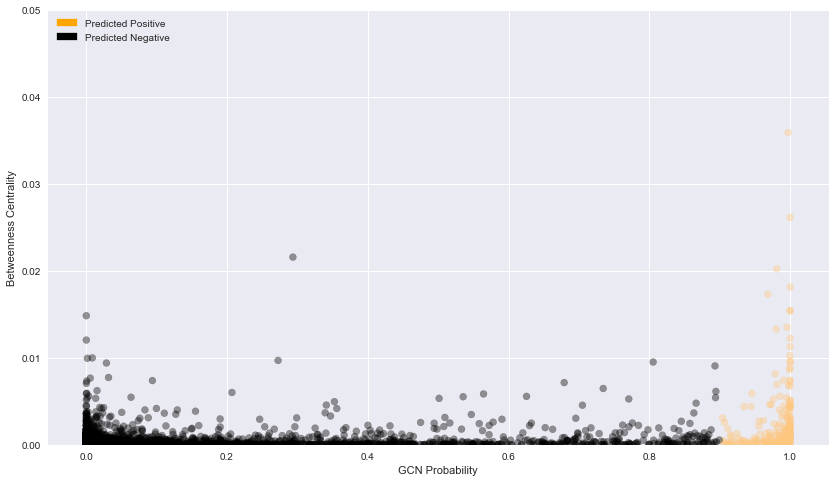

In [57]:
betweenness_list = [betweenness[i] for i in range(network.shape[0])]
betweenness_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID'], axis=1)
betweenness_df['betweenness'] = betweenness_list # works, because node_names has same order as network
betweenness_df['degree'] = network.sum(axis=0)
betweenness_df = betweenness_df.reindex(predictions.index)

fig = plt.figure(figsize=(14, 8))
plt.scatter(predictions.Prob_pos, betweenness_df.betweenness,
            c=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD,
            cmap=plt.cm.copper, alpha=0.4)
plt.gca().set_ylim([0, 0.05])
plt.xlabel('GCN Probability')
plt.ylabel('Betweenness Centrality')
pred = mpatches.Patch(color='orange', label='Predicted Positive')
non_pred = mpatches.Patch(color='black', label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left')
fig.savefig(os.path.join(model_dir, 'betweenness_correlation.png'))

print ("Correlation between betweenness and GCN probability: {}".format(betweenness_df.betweenness.corr(predictions.Prob_pos)))

### Shortest Paths

In [331]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_shortest_paths = nx.shortest_path_length(G)
sp_df = pd.DataFrame(dict(all_shortest_paths))

In [358]:
sp_df['name'] = node_names[:, 0]

(2386, 12130)

In [359]:
# build views for label to label shortest paths and non-label to non-label
label_cond = sp_df.name.isin(pos_predicted.index)
sp_df.drop('name', axis=1, inplace=True)
label_to_label = sp_df.loc[label_cond, label_cond]
nonlabel_to_nonlabel = sp_df.loc[~label_cond, ~label_cond]
label_to_nonlabel = sp_df.loc[~label_cond, label_cond]

(5692996,) (94926049,) (23246798,)


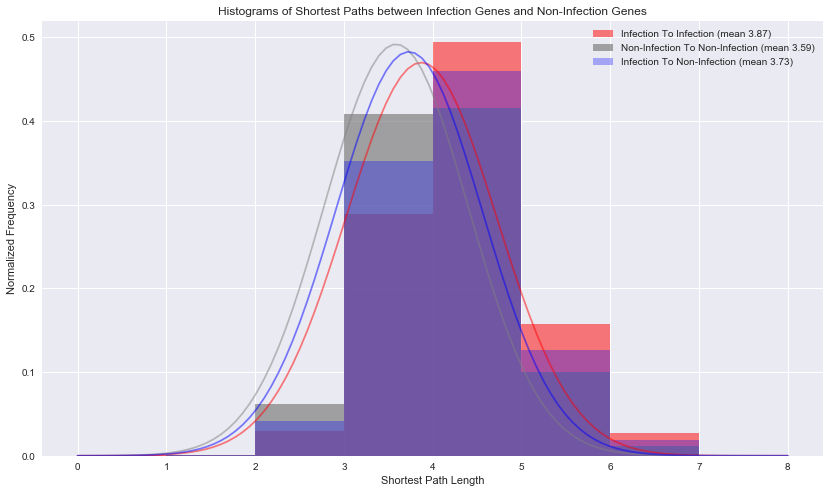

In [361]:
# plot the distributions
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 8, 1)

ltl = pd.Series(label_to_label.values.flatten()).dropna()
ntn = pd.Series(nonlabel_to_nonlabel.values.flatten()).dropna()
ltn = pd.Series(label_to_nonlabel.values.flatten()).dropna()
print (ltl.shape, ntn.shape, ltn.shape)
plt.hist(ltl, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection To Infection (mean {0:.2f})'.format(ltl.mean()))
plt.hist(ntn, bins=bins, alpha=.7, normed=True, color='gray',
         label='Non-Infection To Non-Infection (mean {0:.2f})'.format(ntn.mean()))
plt.hist(ltn, bins=bins, alpha=.3, normed=True, color='blue',
         label='Infection To Non-Infection (mean {0:.2f})'.format(ltn.mean()))
points = np.linspace(0, 8, 100)
plt.plot(points, mlab.normpdf(points, ltl.mean(), ltl.std()), color='red', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ntn.mean(), ntn.std()), color='gray', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ltn.mean(), ltn.std()), color='blue', alpha=0.5)
plt.legend()
plt.title('Histograms of Shortest Paths between Infection Genes and Non-Infection Genes')
plt.xlabel('Shortest Path Length')
plt.ylabel('Normalized Frequency')
fig.savefig(os.path.join(model_dir, 'path_length_distribution.png'))

### Node Degree

In [12]:
degree_df = pd.Series(dict(all_node_degrees))
degree_df = pd.DataFrame(degree_df, index=node_names[:, 0])
degree_df.isnull().sum()

NameError: name 'all_node_degrees' is not defined

In [364]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_node_degrees = G.degree()
degree_df = pd.Series(dict(all_node_degrees))

degree_df['name'] = node_names[:, 0]

# build views for label and non-label degrees
label_cond = degree_df.name.isin(pos_predicted.index)
labels = degree_df[label_cond]
nonlabels = degree_df[~label_cond]
print (labels.shape, nonlabels.shape)

# plot histograms
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 50, 1)
plt.hist(labels, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection Genes (Median {})'.format(labels.median()))
plt.hist(nonlabels, bins=bins, alpha=.7, normed=True, color='gray',
         label='Other Genes (Median {})'.format(nonlabels.median()))
plt.legend()
plt.title('Histograms of Node Degree for Infection and Other Genes')
plt.xlabel('Node Degree')
plt.ylabel('Normalized Frequency')
fig.savefig(os.path.join(model_dir, 'node_degrees.png'))

AttributeError: 'NoneType' object has no attribute 'isin'

### Probability that Neighbor of Infection Gene is also Infection Gene

In [ ]:
# half because of symmetric matrix
num_of_neighbor_labels = label_to_label[label_to_label == 1].count().sum() / 2
prob_neighbor_label = (num_of_neighbor_labels / label_to_label.shape[0]) * 100
print ("Chance of label to have labeled neighbor: {0:.2f} %".format(prob_neighbor_label))

In [ ]:
num_label_nbs = []
num_nbs = []
for label in predictions.index:
    nbs = list(nx.all_neighbors(G, label))
    label_nbs = predictions_for_knowns.index.isin(nbs).sum()
    num_label_nbs.append(label_nbs)
    num_nbs.append(len(nbs))
num_label_nbs = np.array(num_label_nbs)
num_total_nbs = np.array(num_nbs)
print ("Number of labeled neighbors: {}".format(num_label_nbs.sum()))
print ("Number of neighbors total: {}".format(num_total_nbs.sum()))
freq = num_label_nbs.sum()/num_total_nbs.sum()
print ("Chance that neighbor is labeled: {0:.4f}".format(freq))